In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

1. Explicit FDM: Simple to implement, but stability condition restricts time step size.
2. Implicit FDM (Backward Euler, Crank-Nicolson): More stable, suitable for larger time steps, but requires solving a system of equations.
3. FEM: Suitable for complex geometries and boundary conditions, but more complex to implement.
4. Method of Lines: Converts the PDE into ODEs, allowing for the use of ODE solvers.
5. Spectral Methods: Offers high accuracy but is suitable for problems with smooth solutions.

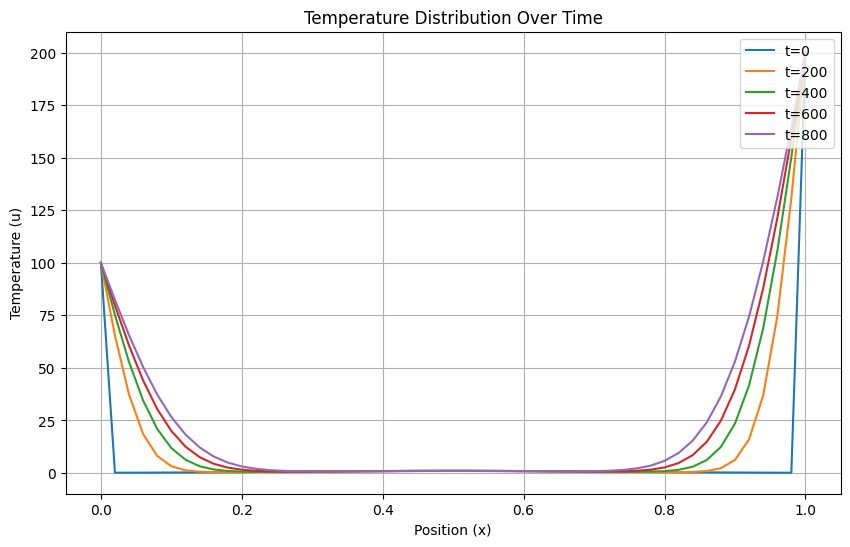

In [3]:
def initialize_domain(L, Nx, T, Nt):
    """ 
    Inititalize time and spatial domain
    Args:
        L (float): Length of road
        Nx (int): Number of spatial points
        T (float): Total Time
        Nt (int): Number of time steps
        
    Returns:
    x (np.array): Discretized spatial domain
    t(np.array): Discretized time domain
    u (np.array): temperature array initialized to zero
    """
    
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T, Nt)
    u = np.zeros((Nt, Nx))
    return x, t, u

def apply_initial_conditions(u, x):
    u[0, :] = np.exp(-10 * (x - 0.5) ** 2)
    return u

def apply_boundary_condition(u, n, condition= 'drichlet'):
    if condition == 'drichlet':
        u[n, 0] = 100
        u[n, -1] = 200
    elif condition == 'neumann': 
        u[n, 0] = 0
        u[n, -1] = 100
    else:
        print("Condition is either drichlet or neumann")
        
def update_temperature(u, alpha, r, Nx, n):
    """
    Update temperature using the explicit FDM formula.
    
    Parameters:
    u (np.array): Temperature array.
    alpha (float): Thermal diffusivity.
    r (float): Stability parameter (alpha * dt / dx^2).
    Nx (int): Number of spatial points.
    n (int): Current time step index.
    
    Returns:
    u (np.array): Updated temperature array at time step n+1.
    """
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + r * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
    return u

def solve_heat_equation(alpha, L, T, Nx, Nt):
    """
    Solve the 1D heat equation using the explicit FDM method.
    
    Parameters:
    alpha (float): Thermal diffusivity.
    L (float): Length of the rod.
    T (float): Total simulation time.
    Nx (int): Number of spatial points.
    Nt (int): Number of time steps.
    
    Returns:
    x (np.array): Discretized spatial domain.
    t (np.array): Discretized time domain.
    u (np.array): Temperature array after solving the heat equation.
    """
    # Initialize domain and parameters
    x, t, u = initialize_domain(L, Nx, T, Nt)
    u = apply_initial_conditions(u, x)
    
    # Calculate spatial and time steps
    dx = L / (Nx - 1)
    dt = T / (Nt - 1)
    r = alpha * dt / dx**2
    
    # Check for stability condition
    if r > 0.5:
        raise ValueError(f"Stability condition not met (r = {r}). Choose smaller dt or larger dx.")
    
    # Time-stepping loop
    for n in range(Nt - 1):
        apply_boundary_condition(u, n)
        u = update_temperature(u, alpha, r, Nx, n)
    
    return x, t, u

def plot_temperature(x, u, Nt, interval=10):
    """
    Plot the temperature distribution over time.
    
    Parameters:
    x (np.array): Discretized spatial domain.
    u (np.array): Temperature array.
    Nt (int): Number of time steps.
    interval (int): Interval of time steps to plot.
    """
    plt.figure(figsize=(10, 6))
    for n in range(0, Nt, interval):
        plt.plot(x, u[n, :], label=f't={n}')
    plt.xlabel('Position (x)')
    plt.ylabel('Temperature (u)')
    plt.title('Temperature Distribution Over Time')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
    
alpha = 0.01
L = 1.0      
T = 0.5       
Nx = 51       
Nt = 1000     

x, t, u = solve_heat_equation(alpha, L, T, Nx, Nt)

plot_temperature(x, u, Nt, interval=200)

This method is only for small time steps and large spatial steps means at stability

In [4]:
### Method 2: 
### (Implicit FDM -- BackWard Euler)
### It is unconditionally stable 

 

### Finite Element Method

## 1D Steady-State Heat Conduction Equation

The 1D steady-state heat conduction equation can be expressed as:


$$-\frac{d}{dx}\left(k \frac{dT}{dx}\right) = Q$$

Where:
- \( k \) = thermal conductivity (constant)
- \( T \) = temperature
- \( Q \) = heat source (constant)


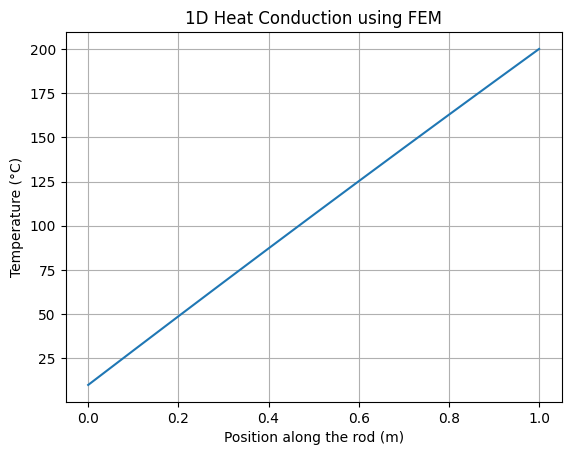

In [5]:
class FEM1DHeatConduction:
    def __init__(self, num_elements, length, k, Q):
        self.num_elements = num_elements
        self.length = length
        self.k = k
        self.Q = Q
        self.nodes = np.linspace(0, length, num_elements + 1)
        self.num_nodes = len(self.nodes)
        self.K = np.zeros((self.num_nodes, self.num_nodes))  # Global stiffness matrix
        self.F = np.zeros(self.num_nodes)                     # Global load vector
        
    def local_stiffness_matrix(self):
        L = self.length / self.num_elements
        K_local = (self.k / L)  * np.array([[1, -1], [-1, 1]])
        return K_local
    def local_load_vector(self):
        L = self.length / self.num_elements  # Length of each element
        F_local = (self.Q * L / 2) * np.array([1, 1])
        return F_local
    
    def assemble_system(self):
        for e in range(self.num_elements):
            K_local = self.local_stiffness_matrix()
            F_local = self.local_load_vector()
            self.K[e: e+2, e: e+2] += K_local
            self.F[e : e+2] += F_local
            
    def apply_boundary_conditions(self, T_left, T_right):
        self.F[0] -= self.K[0, 0] * T_left
        self.F[-1] -= self.K[-1, -1] * T_right
        self.K[0, :] = 0
        self.K[0, 0] = 1
        self.F[0] = T_left

        self.K[-1, :] = 0
        self.K[-1, -1] = 1
        self.F[-1] = T_right
            
    def solve(self, T_left, T_right):
        self.assemble_system()
        self.apply_boundary_conditions(T_left, T_right)
        self.T = np.linalg.solve(self.K, self.F)
        return self.T
    
    def plot_result(self):
        plt.plot(self.nodes, self.T)
        plt.title('1D Heat Conduction using FEM')
        plt.xlabel('Position along the rod (m)')
        plt.ylabel('Temperature (°C)')
        plt.grid()
        plt.show()
        
num_elements = 10
length = 1.0
K = 1.0
Q = 10.0   

solver = FEM1DHeatConduction(num_elements, length, K, Q)
T_left = 10
T_right = 200
temperatures  = solver.solve(T_left, T_right)
solver.plot_result()

### Heat Equation using PINN

In [6]:
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [7]:
def initial_condition(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

def boundary_condition(x, y, t, custom_value):
    return torch.full_like(x, custom_value)

def generate_training_data(num_points):
    x= torch.rand(num_points, 1, requires_grad= True)
    y = torch.rand(num_points, 1, requires_grad= True)
    t = torch.rand(num_points, 1, requires_grad= True)
    
    return x, y, t

def generate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0, 1.0]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points)
    
    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
    
    return x_boundary.view(-1, 1), y_boundary.view(-1, 1)

def generate_boundary_training_data(num_points):
    x_boundary, y_boundary= generate_boundary_points(num_points)
    t = torch.rand(num_points, 1, requires_grad= True)
    
    return x_boundary, y_boundary, t




In [8]:
def pde(x,y,t,model):
    input_data = torch.cat([x,y,t],dim=1)
    u = model(input_data)
    u_x,u_y = torch.autograd.grad(u,[x,y],grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True) 
    u_xx = torch.autograd.grad(u_x,x,grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y,y,grad_outputs= torch.ones_like(u_y), create_graph= True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    heat_eq_residual = 1 * u_xx + 1 * u_yy - u_t
    return heat_eq_residual

In [9]:
def train_PINN(model, num_iterations, num_points):
    optimizer= optim.Adam(model.parameters(), lr= 1e-3)
    for iteration in range(num_iterations):
        optimizer.zero_grad()
        
        x,y,t = generate_training_data(num_points)
        x_b, y_b, t_b= generate_boundary_training_data(num_points)
        
        t_initial = torch.zeros_like(t)
        u_initial = initial_condition(x, y)
        
        custom_value= 0.0
        u_boundary_x = boundary_condition(x_b,y_b,t_b,custom_value)
        u_boundary_y = boundary_condition(y_b,x_b,t_b,custom_value)
        
        residual = pde(x,y,t,model)
        
        loss =  nn.MSELoss()(u_initial, model(torch.cat([x,y,t_initial], dim=1))) + \
                nn.MSELoss()(u_boundary_x, model(torch.cat([x_b,y_b,t_b], dim=1))) + \
                nn.MSELoss()(u_boundary_y, model(torch.cat([y_b,x_b,t_b], dim=1))) + \
                nn.MSELoss()(residual, torch.zeros_like(residual))
                
        loss.backward()
        optimizer.step()
        
        if iteration % 100 ==0:
            print("itration",iteration, "loss",loss )

In [11]:
model = PINN()
num_iterations = 5000
num_points = 1000
train_PINN(model,num_iterations,num_points)

itration 0 loss tensor(0.2178, grad_fn=<AddBackward0>)
itration 100 loss tensor(0.1342, grad_fn=<AddBackward0>)
itration 200 loss tensor(0.1188, grad_fn=<AddBackward0>)
itration 300 loss tensor(0.1103, grad_fn=<AddBackward0>)
itration 400 loss tensor(0.0903, grad_fn=<AddBackward0>)
itration 500 loss tensor(0.0754, grad_fn=<AddBackward0>)
itration 600 loss tensor(0.0662, grad_fn=<AddBackward0>)
itration 700 loss tensor(0.0562, grad_fn=<AddBackward0>)
itration 800 loss tensor(0.0538, grad_fn=<AddBackward0>)
itration 900 loss tensor(0.0494, grad_fn=<AddBackward0>)
itration 1000 loss tensor(0.0431, grad_fn=<AddBackward0>)
itration 1100 loss tensor(0.0371, grad_fn=<AddBackward0>)
itration 1200 loss tensor(0.0316, grad_fn=<AddBackward0>)
itration 1300 loss tensor(0.0301, grad_fn=<AddBackward0>)
itration 1400 loss tensor(0.0293, grad_fn=<AddBackward0>)
itration 1500 loss tensor(0.0251, grad_fn=<AddBackward0>)
itration 1600 loss tensor(0.0210, grad_fn=<AddBackward0>)
itration 1700 loss tensor(

### Result Evaluation

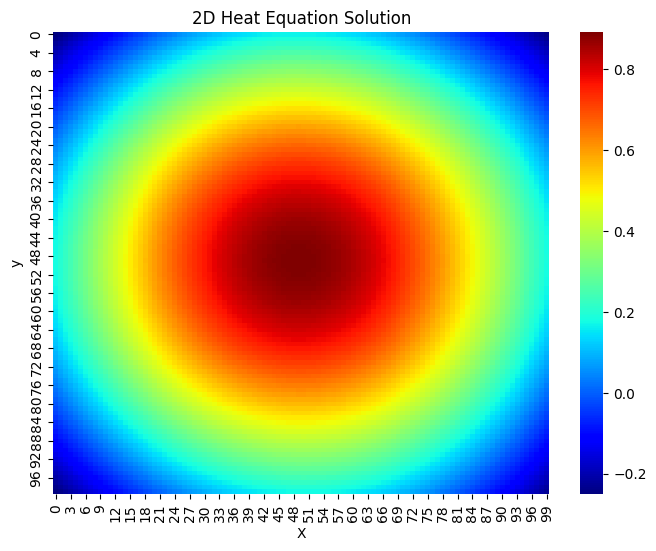

In [15]:
with torch.no_grad():
    x_vals= torch.linspace(0,1, 100)
    y_vals= torch.linspace(0,1,100)
    X, Y= torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0   ## initial time
    
    input_data= torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim= 1)
    solution= model(input_data).reshape(X.shape, Y.shape)
    
    plt.figure(figsize= (8,6))
    sns.heatmap(solution, cmap= 'jet')
    plt.title("2D Heat Equation Solution")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

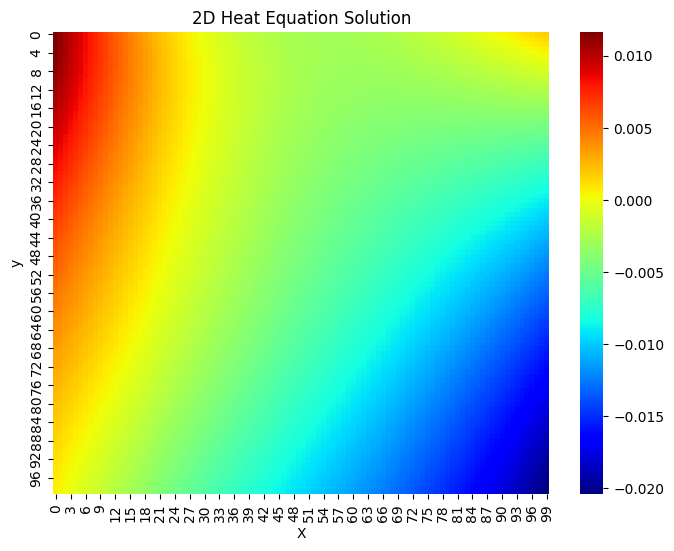

In [16]:
with torch.no_grad():
    x_vals= torch.linspace(0,1, 100)
    y_vals= torch.linspace(0,1,100)
    X, Y= torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 1  ## at t=1
    
    input_data= torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim= 1)
    solution= model(input_data).reshape(X.shape, Y.shape)
    
    plt.figure(figsize= (8,6))
    sns.heatmap(solution, cmap= 'jet')
    plt.title("2D Heat Equation Solution")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

In [17]:
tensor = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
new_tensor = torch.full_like(tensor, 7.0)
print("Original tensor:")
print(tensor)
print("\nNew tensor filled with 7.0:")
print(new_tensor)

Original tensor:
tensor([[1., 2., 3.],
        [4., 5., 6.]])

New tensor filled with 7.0:
tensor([[7., 7., 7.],
        [7., 7., 7.]])


### Using DeepXDE LIBRARY

In [32]:
import deepxde as dde
from deepxde.backend import tf


#### 1D Heat Equation

The 1D heat equation is defined as:
$$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} $$
##### Initial Condition (IC):
The initial condition is given by:
$ u(x, 0) = \sin(\pi x) $
##### Boundary Conditions (BC):
The boundary conditions are:
$ u(0, t) = 0 \quad \text{and} \quad u(1, t) = 0 $

In [35]:
def heat_equation(x, u):
    du_dt = dde.grad.jacobian(u, x, i=0, j=1)
    d2u_dx2= dde.grad.hessian(u, x, component= 0, i=0, j=0)
    alpha= 0.01
    return du_dt - alpha * d2u_dx2

def initial_condition(x):
    return np.sin(np.pi * x[:, 0:1])

def boundary_condition(x, on_boundary):
    return on_boundary

### Generating random data points within domain
geom= dde.geometry.Interval(0, 1)
timedomain= dde.geometry.TimeDomain(0, 1)
domain= dde.geometry.GeometryXTime(geom, timedomain)

ic= dde.IC(
    domain,
    initial_condition,
    lambda _, on_initial: on_initial
)

bc= dde.DirichletBC(
    domain,
    lambda x: np.zeros_like(x[:, 0:1]),
    boundary_condition
)

### Construct PINN model
net= dde.nn.FNN([2] + [50] * 4 + [1], 'tanh', 'Glorot normal')

## defining data and model
data= dde.data.TimePDE(
    domain,
    heat_equation,
    [ic, bc],
    num_domain= 256,
    num_boundary= 64,
    num_initial=64
)

model = dde.Model(data, net)

### Configure training
model.compile('adam', lr= 1e-3, loss_weights= [1,1,1])
losshistory, train_state= model.train(epochs= 10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.091657 s

'compile' took 0.528588 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.35e-01, 8.28e-01, 6.80e-02]    [2.35e-01, 8.28e-01, 6.80e-02]    []  
1000      [2.75e-04, 2.49e-04, 6.02e-05]    [2.75e-04, 2.49e-04, 6.02e-05]    []  
2000      [4.80e-05, 5.50e-05, 2.43e-05]    [4.80e-05, 5.50e-05, 2.43e-05]    []  
3000      [1.48e-05, 1.51e-05, 7.87e-06]    [1.48e-05, 1.51e-05, 7.87e-06]    []  
4000      [5.07e-05, 3.48e-04, 4.08e-04]    [5.07e-05, 3.48e-04, 4.08e-04]    []  
5000      [1.55e-05, 2.64e-04, 4.39e-04]    [1.55e-05, 2.64e-04, 4.39e-04]    []  
6000      [8.42e-06, 1.78e-06, 3.39e-06]    [8.42e-06, 1.78e-06, 3.39e-06]    []  
7000      [8.27e-06, 1.60e-06, 8.99e-07]    [8.27e-06, 1.60e-06, 8.99e-07]    []  
8000      [6.62e-06, 4.54e-07, 7.81e-07]    [6.62e-06, 4.54e-07, 7.81e-07]    []  
9000      [5.26e-06, 3.18e-07, 5.

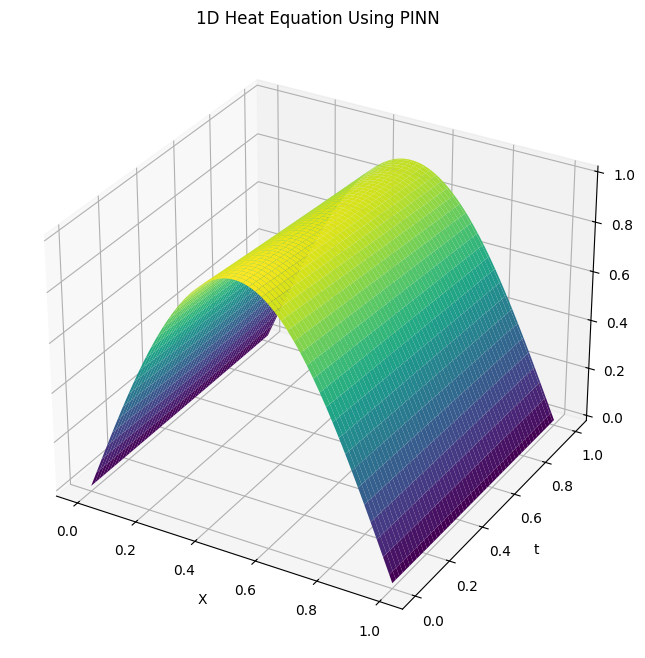

In [36]:
### Visualize the solution
x= np.linspace(0, 1, 100)
t= np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

X_test = np.vstack((np.ravel(X), np.ravel(T))).T

u_pred= model.predict(X_test)

u_pred= u_pred.reshape(X.shape)

fig= plt.figure(figsize= (10, 8))
ax= fig.add_subplot(111, projection= '3d')
ax.plot_surface(X, T, u_pred, cmap= 'viridis', edgecolor= 'none')
ax.set_xlabel('X')
ax.set_ylabel('t')
ax.set_title("1D Heat Equation Using PINN")
plt.show()

Saving loss history to c:\Users\disha\OneDrive\Documents\PINN\loss.dat ...
Saving training data to c:\Users\disha\OneDrive\Documents\PINN\train.dat ...
Saving test data to c:\Users\disha\OneDrive\Documents\PINN\test.dat ...


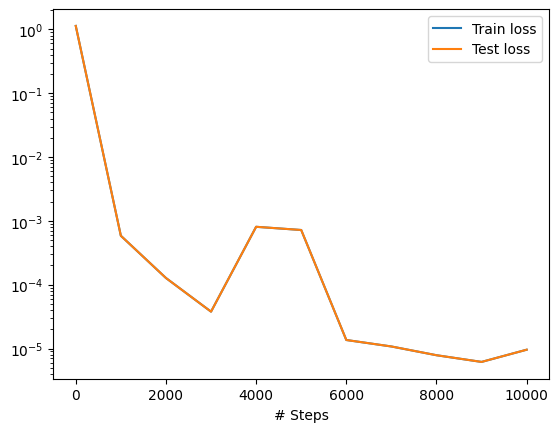

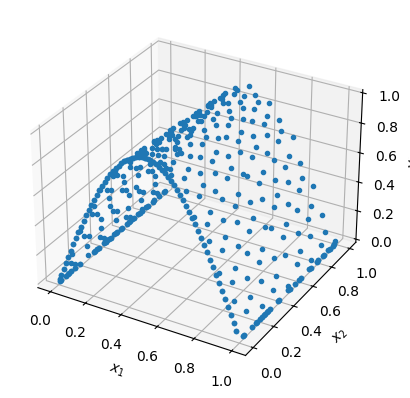

In [37]:
dde.saveplot(losshistory,train_state, issave= True, isplot=True)